In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

In [16]:
# Load engineered features
features_df = pd.read_csv("user_features.csv")

print(features_df.head())
print(features_df.info())

      user  total_logins  unique_days  after_hours  unique_machines  \
0  AAE0190            37           19            0                1   
1  AAF0535            37           19            0                1   
2  AAF0791            37           19            0                1   
3  AAL0706            37           19           19                1   
4  AAM0658            37           19           18                1   

   usb_count  usb_days          employee_name  user_id   O   C   E   A   N  
0        0.0       0.0   August Armando Evans  AAE0190  36  30  14  50  29  
1        0.0       0.0  Athena Amelia Foreman  AAF0535  17  21  36  33  31  
2        0.0       0.0  Aladdin Abraham Foley  AAF0791  14  40  40  50  34  
3        0.0       0.0       April Alika Levy  AAL0706  37  14  28  13  25  
4        0.0       0.0       Abel Adam Morton  AAM0658  43  35  37  36  22  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   

In [17]:
# Prepare data for modeling
print("Original columns:", features_df.columns.tolist())
print("Data types:")
print(features_df.dtypes)

# Drop common identifier/string columns first (so downstream selection is numeric-only)
drop_candidates = [c for c in ["user_id", "user", "employee_name", "employee"] if c in features_df.columns]
if drop_candidates:
    print("Dropping identifier columns:", drop_candidates)
features_clean = features_df.drop(columns=drop_candidates, errors="ignore")

# Select only numeric columns for modeling
numeric_columns = features_clean.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nNumeric columns found: {numeric_columns}")

# Create feature matrix (only numeric columns)
X = features_clean[numeric_columns].copy()
print(f"Feature matrix shape: {X.shape}")

# Safety check: ensure no object columns remain
obj_cols = X.select_dtypes(include=['object']).columns.tolist()
if obj_cols:
    raise ValueError(f"Non-numeric columns still present in X: {obj_cols}")

# Scale the numeric data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Data successfully scaled!")
print(f"Scaled data shape: {X_scaled.shape}")

Original columns: ['user', 'total_logins', 'unique_days', 'after_hours', 'unique_machines', 'usb_count', 'usb_days', 'employee_name', 'user_id', 'O', 'C', 'E', 'A', 'N']
Data types:
user                object
total_logins         int64
unique_days          int64
after_hours          int64
unique_machines      int64
usb_count          float64
usb_days           float64
employee_name       object
user_id             object
O                    int64
C                    int64
E                    int64
A                    int64
N                    int64
dtype: object
Dropping identifier columns: ['user_id', 'user', 'employee_name']

Numeric columns found: ['total_logins', 'unique_days', 'after_hours', 'unique_machines', 'usb_count', 'usb_days', 'O', 'C', 'E', 'A', 'N']
Feature matrix shape: (1000, 11)
Data successfully scaled!
Scaled data shape: (1000, 11)


In [18]:
# Initialize model
iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.05,  # % of anomalies expected
    random_state=42
)

# Fit model
iso_forest.fit(X_scaled)

# Predict anomalies
features_df["anomaly_score"] = iso_forest.decision_function(X_scaled)
features_df["anomaly_label"] = iso_forest.predict(X_scaled)

# Convert labels: -1 = anomaly, 1 = normal
features_df["anomaly_label"] = features_df["anomaly_label"].map({1: 0, -1: 1})

In [19]:
features_df.to_csv("results/anomaly_scores_by_user.csv", index=False)

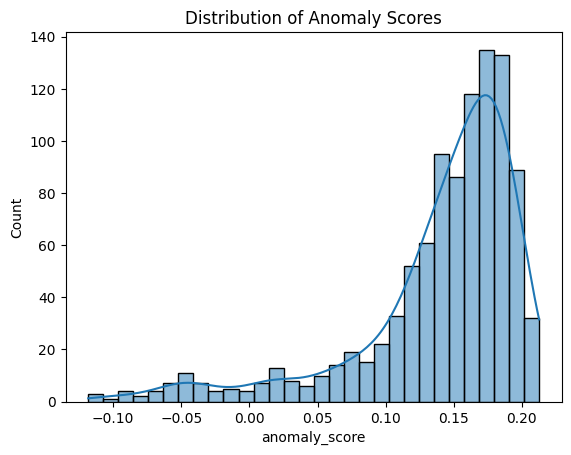

anomaly_label
0    950
1     50
Name: count, dtype: int64


In [20]:
sns.histplot(features_df["anomaly_score"], kde=True)
plt.title("Distribution of Anomaly Scores")
plt.show()

# Count anomalies vs normals
print(features_df["anomaly_label"].value_counts())


In [21]:
if "label" in features_df.columns:
    print(classification_report(features_df["label"], features_df["anomaly_label"]))
    print(confusion_matrix(features_df["label"], features_df["anomaly_label"]))

In [22]:
import joblib
joblib.dump(iso_forest, "models/isolation_forest.pkl")


['models/isolation_forest.pkl']

In [23]:
print("Available columns:", features_df.columns.tolist())


Available columns: ['user', 'total_logins', 'unique_days', 'after_hours', 'unique_machines', 'usb_count', 'usb_days', 'employee_name', 'user_id', 'O', 'C', 'E', 'A', 'N', 'anomaly_score', 'anomaly_label']


In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix


In [25]:
# 1. Set target
target_column = "anomaly_label"

y = features_df[target_column].astype(int).reset_index(drop=True)


In [26]:
# 2. Drop target + IDs from features
drop_cols = ["user", "employee_name", "user_id", "anomaly_label", "anomaly_score"]
X = features_df.drop(columns=drop_cols, errors="ignore")

# Keep only numeric features
X = X.select_dtypes(include=[np.number])

print("Final feature columns:", X.columns.tolist())

Final feature columns: ['total_logins', 'unique_days', 'after_hours', 'unique_machines', 'usb_count', 'usb_days', 'O', 'C', 'E', 'A', 'N']


In [27]:
# 3. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled feature matrix:", X_scaled.shape)
print("Target vector:", y.shape)

Scaled feature matrix: (1000, 11)
Target vector: (1000,)


In [28]:
# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

In [29]:
# 5. Train Isolation Forest (or replace with other model)
model = IsolationForest(n_estimators=1000, contamination=0.05, random_state=42)
model.fit(X_train)

# Predict (convert -1 to 1, 1 to 0 to align with labels)
y_pred = model.predict(X_test)
y_pred = [1 if p == -1 else 0 for p in y_pred]

In [30]:
# 6. Evaluate
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[284   1]
 [  0  15]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       285
           1       0.94      1.00      0.97        15

    accuracy                           1.00       300
   macro avg       0.97      1.00      0.98       300
weighted avg       1.00      1.00      1.00       300



In [31]:
import pandas as pd

insiders_df = pd.read_csv("insiders.csv")
print("Shape:", insiders_df.shape)
print("\nColumns:", insiders_df.columns.tolist())
print("\nSample data:")
print(insiders_df.head())

Shape: (191, 6)

Columns: ['dataset', 'scenario', 'details', 'user', 'start', 'end']

Sample data:
   dataset  scenario     details     user                start  \
0      2.0         1      r2.csv  ONS0995     3/6/2010 1:41:56   
1      3.1         1  r3.1-1.csv  CSF0929  07/01/2010 01:24:58   
2      3.1         2  r3.1-2.csv  CCH0959  08/02/2010 10:34:31   
3      3.2         1  r3.2-1.csv  RCW0822  09/29/2010 21:10:27   
4      3.2         2  r3.2-2.csv  JCE0258  07/12/2010 08:16:02   

                   end  
0    3/20/2010 8:10:12  
1  07/16/2010 06:52:00  
2  09/30/2010 15:04:03  
3  10/15/2010 06:34:52  
4  09/03/2010 16:16:29  


In [32]:
features_df = pd.read_csv("user_features.csv")
insiders_df = pd.read_csv("insiders.csv")
print(features_df.shape, insiders_df.shape)

(1000, 14) (191, 6)


In [33]:
features_df["user"] = features_df["user"].astype(str).str.strip().str.upper()
insiders_df["user"] = insiders_df["user"].astype(str).str.strip().str.upper()

In [34]:
features_df["ground_truth"] = features_df["user"].isin(insiders_df["user"]).astype(int)
print(features_df["ground_truth"].value_counts())

ground_truth
0    930
1     70
Name: count, dtype: int64


In [38]:
# --- New: Use `answers_r42.csv` as absolute ground truth and run a proper train/val/test pipeline (70/20/10)
# This cell replaces use of insiders.csv and fixes leakage by splitting BEFORE fitting scaler/model.
import os
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report

# Paths (notebook lives in Notebook/ so use Notebook/ prefixes when running from repo root)
features_path = os.path.join('Notebook', 'user_features.csv')
answers_path = os.path.join('Notebook', 'answers_r42.csv')
results_dir = os.path.join('Notebook', 'results')
os.makedirs(results_dir, exist_ok=True)

# Try several candidate locations for the features and answers files so the notebook runs
# whether executed from the repo root or from inside the Notebook folder.
cwd = os.path.abspath(os.getcwd())
feature_candidates = [
    features_path,
    os.path.join(cwd, 'Notebook', 'user_features.csv'),
    os.path.join(cwd, 'user_features.csv'),
    os.path.join(cwd, '..', 'Notebook', 'user_features.csv'),
    os.path.join(cwd, '..', 'user_features.csv')
]
answer_candidates = [
    answers_path,
    os.path.join(cwd, 'Notebook', 'answers_r42.csv'),
    os.path.join(cwd, 'answers_r42.csv'),
    os.path.join(cwd, '..', 'Notebook', 'answers_r42.csv'),
    os.path.join(cwd, '..', 'answers_r42.csv')
]

found_feature = None
for p in feature_candidates:
    if os.path.exists(p):
        features_path = p
        found_feature = p
        break

found_answer = None
for p in answer_candidates:
    if os.path.exists(p):
        answers_path = p
        found_answer = p
        break

if not found_feature or not found_answer:
    msg = [f"CWD: {cwd}", "Checked paths for user_features.csv:"]
    msg.extend(feature_candidates)
    msg.append("Checked paths for answers_r42.csv:")
    msg.extend(answer_candidates)
    raise FileNotFoundError("Could not locate required input files.\n" + "\n".join(map(str, msg)))

# Load data
features_df = pd.read_csv(features_path)
answers_df = pd.read_csv(answers_path)

print(f'Loaded features from: {features_path}')
print(f'Loaded answers from: {answers_path}')

# Normalise user keys
if 'user' in features_df.columns and 'user' in answers_df.columns:
    features_df['user'] = features_df['user'].astype(str).str.strip().str.upper()
    answers_df['user'] = answers_df['user'].astype(str).str.strip().str.upper()

# Merge or derive ground truth from answers_r42.csv
if 'ground_truth' in answers_df.columns:
    features_df = features_df.merge(answers_df[['user','ground_truth']], on='user', how='left')
elif 'label' in answers_df.columns:
    # Accept either 'label' or 'ground_truth' column name in answers file
    features_df = features_df.merge(answers_df[['user','label']], on='user', how='left')
    features_df['ground_truth'] = features_df['label'].fillna(0).astype(int)
else:
    # If answers file is just a list of users, mark present users as 1
    features_df['ground_truth'] = features_df['user'].isin(answers_df['user']).astype(int)

features_df['ground_truth'] = features_df['ground_truth'].fillna(0).astype(int)
print('Ground-truth distribution (answers_r42):')
print(features_df['ground_truth'].value_counts())

# Split: train 70% / val 20% / test 10% (stratify by ground_truth)
train_df, temp_df = train_test_split(features_df, test_size=0.3, random_state=42, stratify=features_df['ground_truth'])
val_df, test_df = train_test_split(temp_df, test_size=1/3, random_state=42, stratify=temp_df['ground_truth'])
print('Shapes: train, val, test =', train_df.shape, val_df.shape, test_df.shape)

# Helper to build numeric feature matrix (drop ids & label columns)
drop_cols = ["user", "employee_name", "user_id", "anomaly_label", "anomaly_score", "label", "ground_truth"]
def build_X(df):
    X = df.drop(columns=drop_cols, errors='ignore')
    X = X.select_dtypes(include=[np.number])
    return X

X_train = build_X(train_df)
X_val = build_X(val_df)
X_test = build_X(test_df)

y_train = train_df['ground_truth'].astype(int)
y_val = val_df['ground_truth'].astype(int)
y_test = test_df['ground_truth'].astype(int)

print('Numeric feature counts: train={}, val={}, test={}'.format(X_train.shape[1], X_val.shape[1], X_test.shape[1]))

# Fit scaler on train only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# --- New: Train a lightweight autoencoder on train set (dense AE)
try:
    from tensorflow.keras import layers, models, optimizers, callbacks
    input_dim = X_train_scaled.shape[1]
    encoding_dim = max(8, min(64, input_dim // 2))
    ae = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(encoding_dim, activation='relu'),
        layers.Dense(max(encoding_dim//2, 4), activation='relu'),
        layers.Dense(encoding_dim, activation='relu'),
        layers.Dense(input_dim, activation='linear'),
    ])
    ae.compile(optimizer=optimizers.Adam(1e-3), loss='mse')
    es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = ae.fit(X_train_scaled, X_train_scaled,
                     validation_data=(X_val_scaled, X_val_scaled),
                     epochs=200, batch_size=32, verbose=1, callbacks=[es])
    os.makedirs('models', exist_ok=True)
    ae.save('models/autoencoder.keras')
    print('Autoencoder trained and saved to models/autoencoder.keras')
    # compute AE MSE on val and test
    recon_val = ae.predict(X_val_scaled)
    ae_mse_val = np.mean(np.square(X_val_scaled - recon_val), axis=1)
    recon_test = ae.predict(X_test_scaled)
    ae_mse_test = np.mean(np.square(X_test_scaled - recon_test), axis=1)
    val_df['ae_mse'] = ae_mse_val
    test_df['ae_mse'] = ae_mse_test
except Exception as e:
    print('Autoencoder training skipped or failed:', e)
    ae = None

# Train IsolationForest on train set only
iso = IsolationForest(n_estimators=1000, contamination=0.05, random_state=42)
iso.fit(X_train_scaled)

# Compute scores on val and test
scores_val = iso.decision_function(X_val_scaled)
scores_test = iso.decision_function(X_test_scaled)

# Sweep contamination percentiles on validation to pick best F1
percs = np.linspace(0.001, 0.5, 500)
rows = []
for p in percs:
    thresh = float(np.nanpercentile(scores_val[~np.isnan(scores_val)], 100 * p))
    y_val_pred = (scores_val <= thresh).astype(int)
    prec, rec, f1, _ = precision_recall_fscore_support(y_val, y_val_pred, average='binary', zero_division=0)
    rows.append({'contamination': float(p), 'threshold': thresh, 'precision': float(prec), 'recall': float(rec), 'f1': float(f1), 'predicted_positives': int(np.nansum(y_val_pred))})

df_tune = pd.DataFrame(rows)
best_row = df_tune.loc[df_tune['f1'].idxmax()]
selected_contamination = float(best_row['contamination'])
selected_threshold = float(best_row['threshold'])
print('\nBest validation F1:')
print(best_row.to_dict())

# Save tuning table and selected threshold
df_tune.to_csv(os.path.join(results_dir, 'threshold_tuning.csv'), index=False)
with open(os.path.join(results_dir, 'selected_threshold.json'), 'w') as fh:
    json.dump({'contamination': selected_contamination, 'threshold': selected_threshold, 'f1': float(best_row['f1'])}, fh)
print('Saved tuning table and selected threshold to', results_dir)

# Evaluate on test set with selected threshold
y_test_pred = (scores_test <= selected_threshold).astype(int)
print('\nTest set results (selected threshold applied):')
print('Contamination chosen from val: {:.4f}, threshold: {:.6f}'.format(selected_contamination, selected_threshold))
print('\nConfusion Matrix:\n', confusion_matrix(y_test, y_test_pred))
print('\nClassification Report:\n', classification_report(y_test, y_test_pred, target_names=['Normal','Insider'], zero_division=0))

# Save per-user anomaly scores/labels for the whole dataset (use scaler fitted on train + iso fitted on train)
# Ensure the full feature set uses the same columns and ordering as the training features
full_X = build_X(features_df)
try:
    # If X_train is a DataFrame, reindex full_X to match training columns (fill missing with 0)
    if hasattr(X_train, 'columns'):
        feature_cols = X_train.columns.tolist()
        full_X = full_X.reindex(columns=feature_cols, fill_value=0)
except Exception:
    # Fall back to using full_X as-is if anything unexpected occurs
    pass

# Now safe to transform with the scaler fitted on the training set
full_X_scaled = scaler.transform(full_X)
full_scores = iso.decision_function(full_X_scaled)
full_df_out = features_df[['user']].copy()
full_df_out['anomaly_score'] = full_scores
# If autoencoder was trained, compute AE MSE on the full set and attach
if 'ae' in globals() and ae is not None:
    try:
        recon_full = ae.predict(full_X_scaled)
        full_df_out['ae_mse'] = np.mean(np.square(full_X_scaled - recon_full), axis=1)
    except Exception as e:
        print('Failed to compute AE mse on full set:', e)

full_df_out['anomaly_label'] = (full_df_out['anomaly_score'] <= selected_threshold).astype(int)
full_df_out.to_csv(os.path.join(results_dir, 'anomaly_scores_by_user.csv'), index=False)
print('Saved per-user anomaly scores/labels to', os.path.join(results_dir, 'anomaly_scores_by_user.csv'))


Loaded features from: c:\Users\sniki\OneDrive\Desktop\Insider Threat Anamoly Detection\Notebook\user_features.csv
Loaded answers from: c:\Users\sniki\OneDrive\Desktop\Insider Threat Anamoly Detection\Notebook\answers_r42.csv
Ground-truth distribution (answers_r42):
ground_truth
0    930
1     70
Name: count, dtype: int64
Shapes: train, val, test = (700, 16) (200, 16) (100, 16)
Numeric feature counts: train=11, val=11, test=11
Epoch 1/200
Epoch 1/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.8568 - val_loss: 0.7188
Epoch 2/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.8568 - val_loss: 0.7188
Epoch 2/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8132 - val_loss: 0.6942
Epoch 3/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8132 - val_loss: 0.6942
Epoch 3/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7896 - val_loss: 0.6782
Epoch 4/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7896 - val_loss: 0.6782
Epoch 4/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/

In [39]:
from sklearn.metrics import confusion_matrix, classification_report
import os

# Actual labels (from insider truth file)
y_true = features_df["ground_truth"].astype(int)

# Load saved predictions (results/anomaly_scores_by_user.csv) and align by user
res_path = os.path.join("results", "anomaly_scores_by_user.csv")
if not os.path.exists(res_path):
    raise FileNotFoundError(f"Results file not found at {res_path}")
res = pd.read_csv(res_path)

# Standardize user column if present
if 'user' in features_df.columns and 'user' in res.columns:
    left = features_df[['user']].copy()
    left['user'] = left['user'].astype(str).str.strip().str.upper()
    res['user'] = res['user'].astype(str).str.strip().str.upper()
    merged = left.merge(res, on='user', how='left')
else:
    # No user alignment possible — try to use order-preserving predictions
    merged = res.copy()

# Decide predicted labels: prefer anomaly_label column, else infer from anomaly_score using contamination
if 'anomaly_label' in merged.columns:
    y_pred = merged['anomaly_label'].fillna(0).astype(int)
elif 'anomaly_score' in merged.columns:
    # Anomaly score from IsolationForest: lower -> more anomalous
    scores = merged['anomaly_score'].astype(float)
    # default contamination fallback
    contamination = 0.05
    thresh = np.nanpercentile(scores.dropna(), 100 * contamination)
    # predict anomaly if score <= thresh (anomalies are low scores)
    y_pred = (scores <= thresh).astype(int).fillna(0)
else:
    raise KeyError('No anomaly_label or anomaly_score column found in results file.')

# If merged includes extra rows or alignment used, ensure lengths match by selecting same index as features_df
if 'user' in features_df.columns and 'user' in merged.columns:
    # merged length equals features_df
    pass
else:
    # If shapes mismatch, attempt to trim/pad
    if len(y_pred) != len(y_true):
        raise ValueError(f"Length mismatch after loading predictions: y_true={len(y_true)}, y_pred={len(y_pred)}. Ensure results file aligns with features_df or contains 'user' column for merging.")

# Print class distribution and diagnostics
print("Ground-truth counts:\n", y_true.value_counts())
print("Predicted counts:\n", pd.Series(y_pred).value_counts())

# Generate metrics
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=["Normal", "Insider"], zero_division=0)

print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

Ground-truth counts:
 ground_truth
0    930
1     70
Name: count, dtype: int64
Predicted counts:
 anomaly_label
0    950
1     50
Name: count, dtype: int64

Confusion Matrix:
 [[892  38]
 [ 58  12]]

Classification Report:
               precision    recall  f1-score   support

      Normal       0.94      0.96      0.95       930
     Insider       0.24      0.17      0.20        70

    accuracy                           0.90      1000
   macro avg       0.59      0.57      0.57      1000
weighted avg       0.89      0.90      0.90      1000

